In [1]:
import tensorflow as tf
import keras
from keras import layers

import gym
import numpy as np

import math
import os
import random
import time

import matplotlib.pyplot as plt

from collections import namedtuple, deque
from itertools import count

from IPython import display

In [2]:
Experience = namedtuple(typename='Experience', field_names=('state', 'action', 'next_state', 'reward', 'done'))

In [3]:
class ReplayMemory:
    def __init__(self, capacity: int):
        self.memory = deque([], maxlen=capacity)

    def push(self, experience: Experience):
        self.memory.append(experience)

    def sample(self, batch_size: int) -> list[Experience]:
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size: int) -> bool:
        return len(self) >= batch_size

    def __len__(self) -> int:
        return len(self.memory)

In [4]:
class EpsilonGreedyStrategy:
    def __init__(self, start: float, end: float, decay: float):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step: int) -> float:
        return EpsilonGreedyStrategy.exploration_rate(self.start, self.end, self.decay, current_step)
    
    def __call__(self, current_step: int) -> float:
        return self.get_exploration_rate(current_step)

    @staticmethod
    def exploration_rate(start: float, end: float, decay: float, current_step: int):
        return end + (start - end) * math.exp(-1 * current_step * decay)

In [5]:
def create_q_dnn_model() -> keras.Sequential:
    model = keras.Sequential((
        layers.InputLayer(input_shape=(1,)),
        layers.Dense(units=128, activation='relu'),
        layers.Dense(units=64, activation='relu'),
        layers.Dense(units=32, activation='relu'),
        layers.Dense(units=4),
    ))
    return model

In [6]:
def extract_tensors(experiences: list[Experience]) -> tuple[tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor]:
    batch = Experience(*zip(*experiences))
    t1 = tf.convert_to_tensor(batch.state)
    t2 = tf.convert_to_tensor(batch.action)
    t3 = tf.convert_to_tensor(batch.reward)
    t4 = tf.convert_to_tensor(batch.next_state)
    t5 = tf.convert_to_tensor(batch.done)
    return t1, t2, t3, t4, t5

In [7]:
def get_next_q_max(target_net: keras.Model, next_states: np.ndarray, done: np.ndarray) -> tf.Tensor:
    not_finished = ~done
    non_final_states = tf.boolean_mask(next_states, not_finished)
    batch_size = tf.shape(next_states)[0]
    values = tf.zeros(batch_size, dtype=tf.float32)

    if tf.reduce_any(not_finished):
        max_q_values = tf.reduce_max(target_net(non_final_states), axis=1)
        invalid_indices = tf.where(not_finished)  # Get the indices where valid is False
        invalid_indices_expanded = tf.squeeze(invalid_indices, axis=1)  # Squeeze the indices to shape (num_false_positions,)
        values = tf.tensor_scatter_nd_update(values, invalid_indices_expanded[:, tf.newaxis], max_q_values)

    return values

In [8]:
def plot(episode_durations: list[int], title: str):
    plt.figure(1)
    plt.clf()
    plt.title(title)
    plt.xlabel('episodes')
    plt.ylabel('duration (steps)')
    plt.plot(episode_durations)
    plt.pause(.001)

def plot_diagram(rewards: list[int], title: str, display_trigger: bool):
    has_rewards_sum = sum(rewards)
    no_rewards_sum = len(rewards) - has_rewards_sum
    sizes = [no_rewards_sum, has_rewards_sum]
    labels = ['no rewards', 'got rewards']  # Convert labels to a list
    colors = ['orange', 'green']  # Convert colors to a list
    plt.figure(1)
    plt.clf()
    plt.title(title)
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    if display_trigger: display.display(plt.gcf())

In [9]:
batch_size = 256
gamma = .999
eps_start = 1
eps_end = .01
eps_decay = .001
target_update = 10
memory_size = 100_000
lr = .001
num_episodes = 20_000

In [26]:
memory = ReplayMemory(memory_size)
epsilon_strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

policy_net = create_q_dnn_model()
# policy_net.compile()

target_net = create_q_dnn_model()
target_net.set_weights(policy_net.get_weights())
# target_net.compile()

target_net.trainable = False

In [30]:
show_episodes = False

render_mode = 'human' if show_episodes else None
env = gym.make('FrozenLake-v1', render_mode=render_mode)

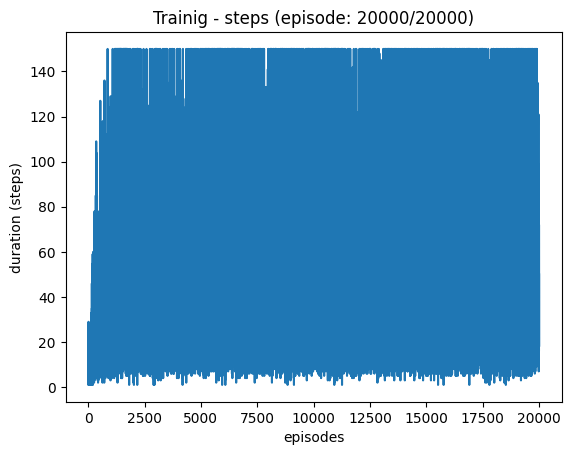

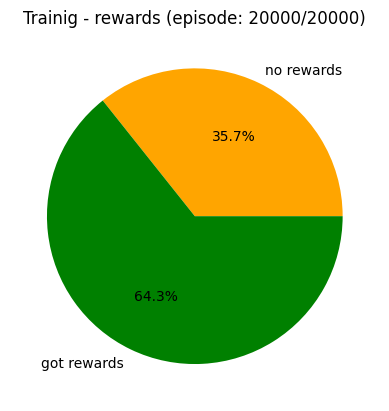

In [31]:
steps_per_episode = 150
cur_step = 0
episode_durations = list()
episode_rewards = list()

for episode in range(num_episodes):
    state, observation = env.reset()
    done = False
    rewards_per_episode = 0
    # time.sleep(1)
    for timestep in count():
        if show_episodes: env.render()

        if epsilon_strategy(cur_step) > random.random():
            action = random.randrange(2)
        else:
            state_tensor = tf.convert_to_tensor([state])
            action = policy_net(state_tensor).numpy().argmax(axis=1)[0]
        cur_step += 1

        next_state, reward, done, truncated, info = env.step(action)
        # done = truncated if truncated else done
        done = done if timestep < steps_per_episode else True
        rewards_per_episode += reward

        memory.push(Experience([state], action, [next_state], reward, done))
        state = next_state

        if memory.can_provide_sample(batch_size):
            with tf.GradientTape() as tape:
                experiences = memory.sample(batch_size)
                states, actions, rewards, next_states, valid = extract_tensors(experiences)
                actions = tf.expand_dims(actions, axis=-1)
                current_q_values = tf.gather(policy_net(states), actions, batch_dims=1)
                next_q_values = get_next_q_max(target_net, next_states, valid)
                target_q_values = (next_q_values * gamma) + rewards

                loss = tf.keras.losses.MeanSquaredError()(current_q_values, tf.expand_dims(target_q_values, axis=-1))

            gradients = tape.gradient(loss, policy_net.trainable_variables)
            optimizer.apply_gradients(zip(gradients, policy_net.trainable_variables))

        if done:
            episode_durations.append(timestep)
            episode_rewards.append(rewards_per_episode)
            display.clear_output()
            episode_num = episode + 1
            plot(episode_durations, title=f'Trainig - steps (episode: {episode_num}/{num_episodes})')
            plot_diagram(episode_rewards, title=f'Trainig - rewards (episode: {episode_num}/{num_episodes})', display_trigger=(episode_num < num_episodes))
            break
    
    if episode % target_update == 0:
        target_net.set_weights(policy_net.get_weights())

In [32]:
env.close()

In [10]:
models_path = 'frozen_lake_tf'
model_appendix = '_%d' % num_episodes
policy_net_path = models_path + '/policy_net' + model_appendix
target_net_path = models_path + '/target_net' + model_appendix

In [34]:
if not os.path.exists(models_path): os.mkdir(models_path)
policy_net.save(policy_net_path)
target_net.save(target_net_path)

INFO:tensorflow:Assets written to: frozen_lake_tf/policy_net_20000\assets
INFO:tensorflow:Assets written to: frozen_lake_tf/target_net_20000\assets


In [11]:
policy_net = keras.models.load_model(policy_net_path, compile=False)
target_net = keras.models.load_model(target_net_path, compile=False)

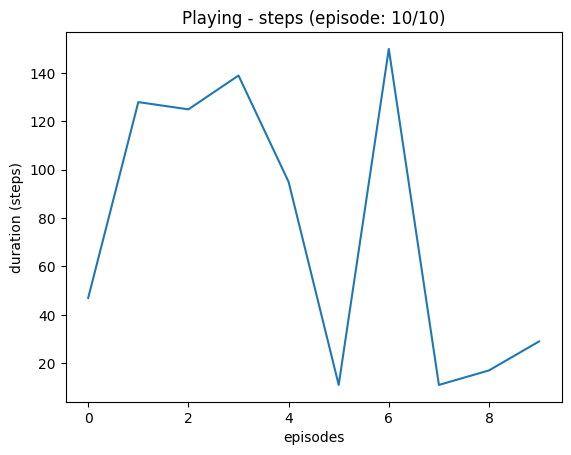

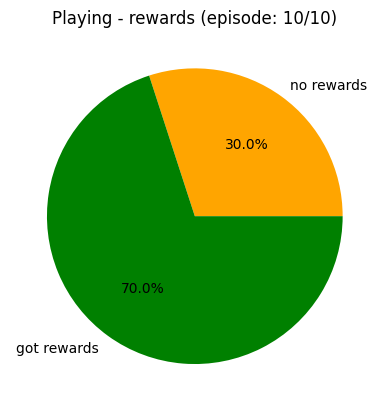

In [12]:
env = gym.make('FrozenLake-v1', render_mode='human')

episode_durations = list()
episode_rewards = list()
episodes_to_play = 10
steps_per_episode = 150

for episode in range(episodes_to_play):
    state, observation = env.reset()
    done = False
    rewards_per_episode = 0
    # time.sleep(1)
    for timestep in count():
        env.render()

        state_tensor = tf.convert_to_tensor([state])
        action = policy_net.predict(state_tensor, verbose=0).argmax(axis=1)[0]

        next_state, reward, done, truncated, info = env.step(action)
        # done = truncated if truncated else done
        done = done if timestep < steps_per_episode else True
        state = next_state
        rewards_per_episode += reward

        if done:
            episode_durations.append(timestep)
            episode_rewards.append(rewards_per_episode)
            display.clear_output()
            episode_num = episode + 1
            plot(episode_durations, title=f'Playing - steps (episode: {episode_num}/{episodes_to_play})')
            plot_diagram(episode_rewards, title=f'Playing - rewards (episode: {episode + 1}/{episodes_to_play})', display_trigger=(episode_num < episodes_to_play))
            break

In [13]:
env.close()